# Práctico 4:

1. Implementar un pipeline de clasificación con la muestra que se vió en clase. El código para traer el dataset es el siguiente:

## MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())
X, y = mnist["data"], mnist["target"]

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

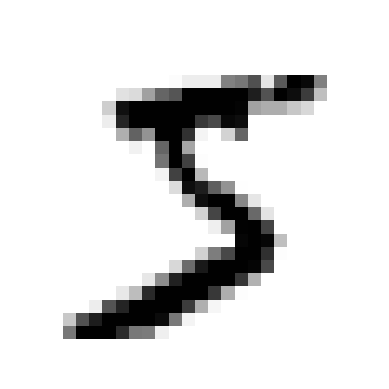

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]


'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de y_test:", y_test.shape)

Tamaño de X_train: (60000, 784)
Tamaño de X_test: (10000, 784)
Tamaño de y_train: (60000,)
Tamaño de y_test: (10000,)


## Clasificador Binario

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])


array([ True])

## Medición de Rendimiento o Accuracy

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)


In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=None)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


## Matriz de confusión

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_predictions)

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [33]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

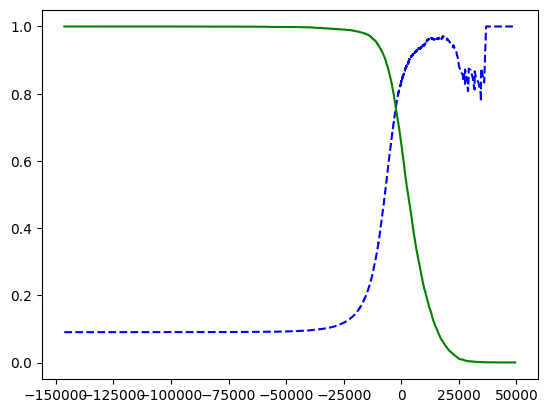

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  [...] # highlight the threshold and add the legend, axis label, and grid


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()




In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## Curva ROC

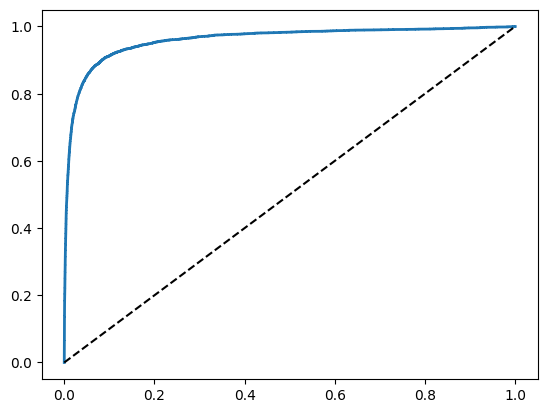

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
  [...] # Add axis labels and grid
  
plot_roc_curve(fpr, tpr)
plt.show()



In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

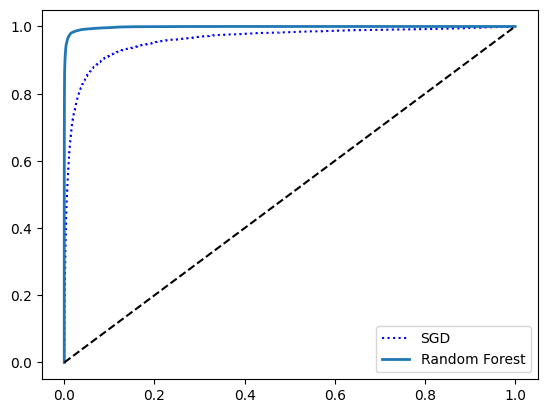

In [46]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

## Clasificacion Multiclase

In [48]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

In [54]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

#Cuidado, ejecucion muy pesada

array([5], dtype=uint8)

In [55]:
len(ovr_clf.estimators_)

10

In [56]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [57]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [58]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Analisis del error

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

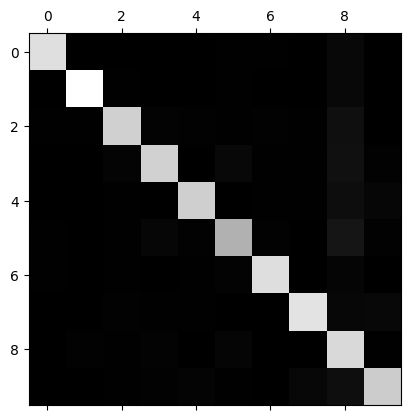

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()


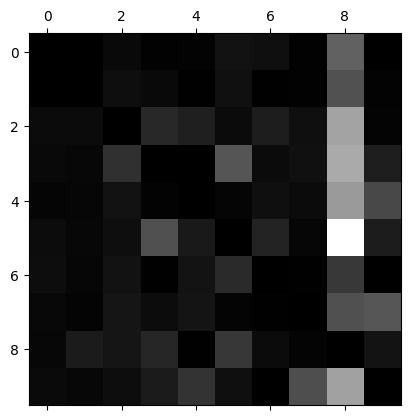

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


In [74]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

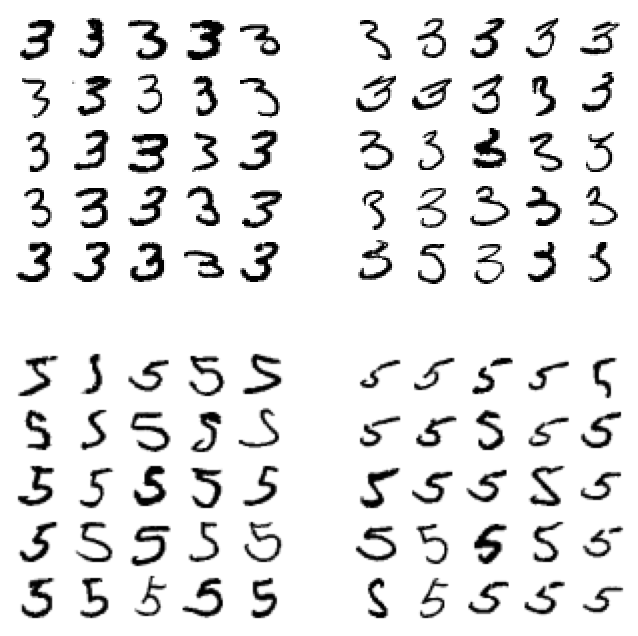

In [75]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


## Clasificación de múltiples etiquetas

In [76]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [77]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [78]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#Cuidado, ejecucion muy pesada

0.976410265560605

## Clasificación de múltiples salidas

In [91]:
import os

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [92]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


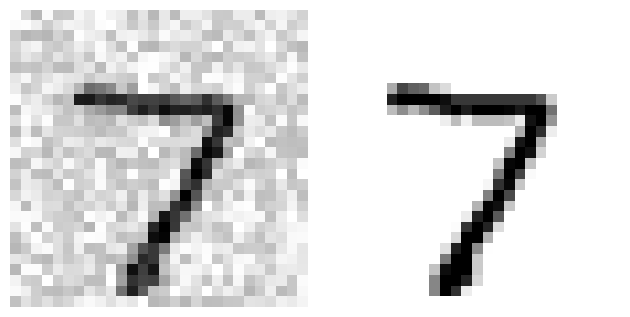

In [93]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()


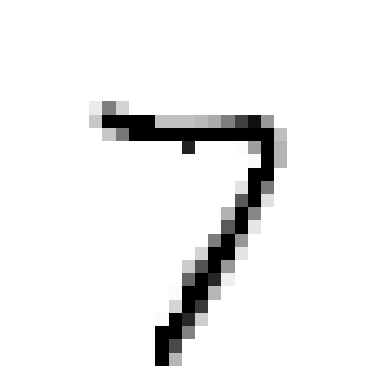

In [94]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)


## Regresiones (no va en el parcial)

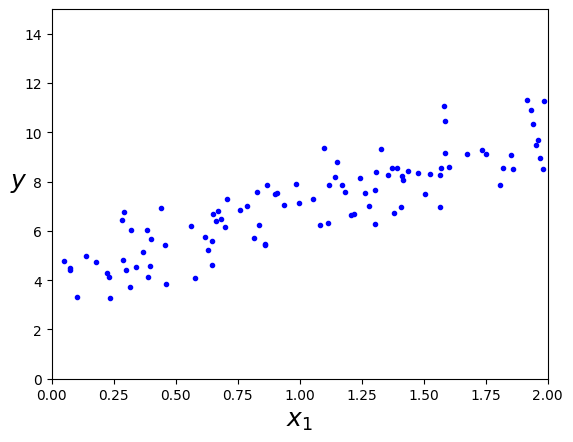

In [101]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [98]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.27670983],
       [2.71338242]])

In [99]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.27670983],
       [9.70347468]])

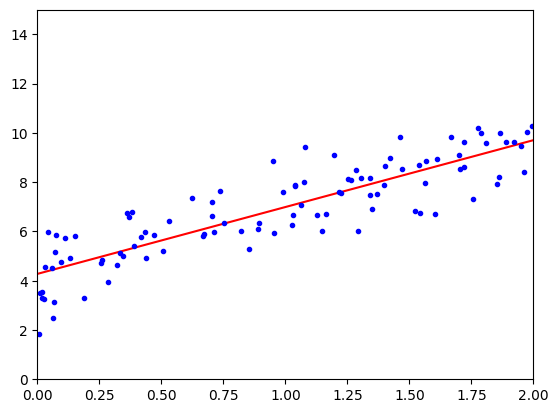

In [100]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [102]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([4.10663629]), array([[2.90184186]]))

In [103]:
lin_reg.predict(X_new)


array([[4.10663629],
       [9.91032001]])

In [104]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd


array([[7.0399546],
       [0.0353049]])

In [105]:
np.linalg.pinv(X_b).dot(y)


array([[7.0399546],
       [0.0353049]])

Todo lo relacionado a Descenso de gradiente

In [106]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100
theta = np.random.randn(2,1) # random initialization
for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

theta

array([[7.0399546],
       [0.0353049]])

Todo lo relacionado con Descenso de Gradiente Estocástico

In [112]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

theta

array([[ 7.15879272],
       [-0.01224749]])

In [118]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.06794282]), array([2.86684024]))

2. Luego conteste las siguientes preguntas:
- ¿Que es un clasificador Binario?
- ¿Por qué un modelo con gran accuracy puede que no ser un buen modelo?
- ¿Por qué existe un trade off entre presicion y recall?
- ¿F1 es la mejor métrica que se puede utilizar al momento de optimizar un modelo? Justifique.
- ¿Para que sirve la curva ROC?